# Initialization

1) Set alpha and beta to zero, but apply random perturbations to azimuth and zenith (ie rotate the plane normal a bit)
2) Give the user their starting image


In [81]:
#!pip install pandas --upgrade

In [36]:
## Installs and Imports

import math
import random
from numpy import linalg as LA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from Rotating import rotate_vector_alpha, rotate_vector_beta, calculate_angle, calculate_azimuth
from Projecting import circle_point
from PIL import Image
import io
import os


In [37]:
##Nominal tilt settings, as reported by microscopy stage
nominal_alpha = 0
nominal_beta = 0

##To handle the rotations, this code imagines the grid (and the hole) as a plane and keeps track of the plane normal as tilts are applied
#For mathematical simplicity, let alpha tilt be a simple rotation about the x-axis, and beta tilt a simple rotation about the y-axis
#When the grid is flat the plane normal is parallel to the z-axis
starting_norm = np.array([0,0,1])

##Pick an arbitraryish center and radius - just need a good pseudo-micrograph
center = np.array([5,5,5])
r = 4
t_range=np.linspace(0,2*np.pi, 500)


##Pick random values to perturb the norm - simulating a bent grid here so not flat at alpha and beta = 0
perturb_alpha = random.uniform(-5,20)
perturb_beta = random.uniform(-5,5)
norm_alpha_p = rotate_vector_alpha(starting_norm, perturb_alpha)
perturbed_norm = rotate_vector_beta(norm_alpha_p, perturb_beta)

##Use the normal to find azimuth and zenith:
theta_r = calculate_angle(perturbed_norm, np.array([0,0,1]))
phi_r = calculate_azimuth(perturbed_norm)
#print("Perturbed_nom is now")
#print(perturbed_norm)
#print(f"Phi is {phi_r} and theta is {theta_r}")


Else


In [38]:
##Takes the azimuth ans zenith and finds points on the circle
def circle_point(theta, phi, center, t):
    '''
    Uses the parametric equation for a circle in 3 dimensions to find points on the circle (one point at at time)
    Parameters:
        theta: zenith
        phi: azimuth
        center: x,y,z coordinates of the center
        t: parameter of the parametric equation, in radians
    Returns:
        x,y,z coordinates of a point on the circle
    '''
    n = np.array( [math.cos(phi_r)*math.sin(theta_r), math.sin(phi_r)*math.sin(theta_r), math.cos(phi_r)] )
    u = np.array( [-1*math.sin(phi_r), math.cos(phi_r), 0] )
    w = np.array( [math.cos(phi_r)*math.cos(theta_r), math.sin(phi_r)*math.cos(theta_r), -1*math.sin(phi_r)] )
    
    return center + r*math.cos(t)*u + r*math.sin(t)*w


##Find the points for the starting orientation:
circle_points = np.zeros([len(t_range),3])

i=0
for t in t_range:
    current_point = circle_point(theta_r, phi_r, center, t)
    circle_points[i,:] = current_point
    i+=1

### Plot Initial Orientation of Hole and Its Projection

Text(0.5, 0.92, 'Initial Orientation of Grid')

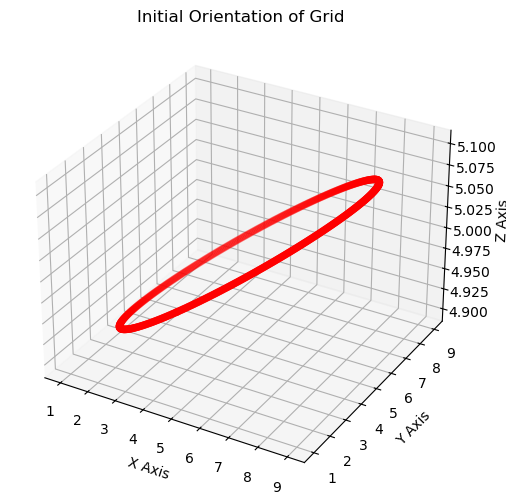

In [39]:
# Create a figure and 3D axis
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

x=circle_points[:,0]
y=circle_points[:,1]
z=circle_points[:,2]

# Create scatter plot
ax.scatter3D(x, y, z, color='red', marker='o')

# Labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Initial Orientation of Grid')

Text(0.5, 0.92, 'Initial Orientation')

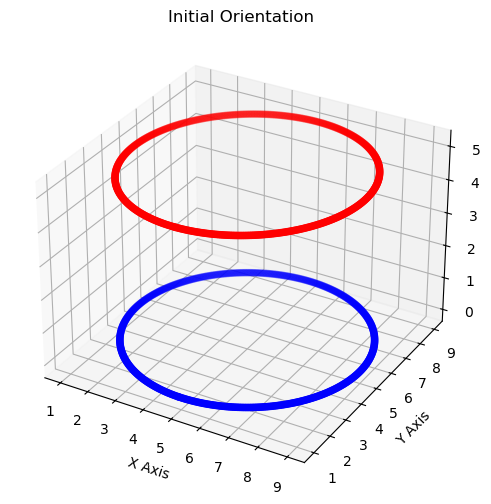

In [40]:
### Project the Points Down:

from skspatial.objects import Plane, Point, Vector
from skspatial.plotting import plot_3d

def project_into_xy_plane(points):
    '''Use skspatial to project the circle in 3 dimensions down into the xy plane (as it would appear in a micrograph) yielding an ellipse
    Does not take the plane as an argument, we always project into xy plane
    Arguments:
        points: N*3 numpy array of points in (x,y,z) format
    Returns:
        projected_points: N*3 numpy array of projected points in (x,y,z) format
    '''
    plane = Plane(point=[0, 0, 0], normal=[0, 0, 2])
    projected_points = np.zeros([len(points),3])
    
    for i in range(0,len(points)):
        point = points[i,:]
        point_projected = plane.project_point(point)
        projected_points[i,:] = point_projected
    
    return projected_points

##Plot The Projection and the initial circle
projected_points = project_into_xy_plane(circle_points)
    
x1=projected_points[:,0]
y1=projected_points[:,1]
z1=projected_points[:,2]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(x, y, z, color='red', marker='o')
ax.scatter3D(x1, y1, z1, color='blue', marker='o')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Initial Orientation')



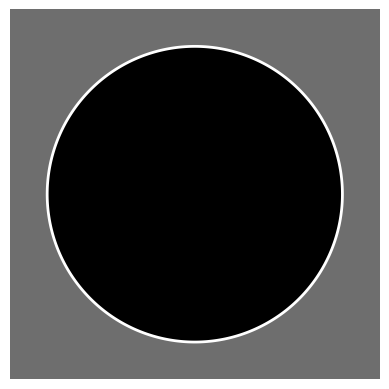

In [41]:
##Generate Pseudomicrograph

import matplotlib

fig, ax = plt.subplots() # Ensure equal aspect ratio for true shape


##Use matplotlib.patches.Polygon to create a filled ellipse from our projected points, plot in black with white outline to mimic a HAADF image of a hole in a real grid
plot_patch = matplotlib.patches.Polygon(projected_points[:, 0:2], 
                                        closed=True,
                                        edgecolor='w',
                                        facecolor='k',
                                        lw=2)

# Add the ellipse to the axes - use equal axes to ensure it displays correctly
ax.set_aspect('equal')
ax.add_patch(plot_patch)

# Set plot limits and show
ax.set_facecolor((.43, .43, .43))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

##Make the Axes Invisible - so it looks like a microscope picture
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

##Save the png and display your image
plt.savefig('Circle2.png', dpi=300, bbox_inches='tight')
plt.show()


## Apply a Tilt Update:

In [42]:
tilt_alpha = 20 #Degrees
tilt_beta = 12 #Degrees

nominal_alpha += tilt_alpha
nominal_beta += tilt_beta

In [43]:
## Rotate the normal by applied alpha and beta:

norm_alpha = rotate_vector_alpha(perturbed_norm, tilt_alpha)
norm_beta = rotate_vector_beta(norm_alpha, tilt_beta)

##Recalculate azimuth and zenith:

theta_r = calculate_angle(norm_alpha, np.array([0,0,1]))
phi_r = calculate_azimuth(norm_beta)
print(f"Phi is {phi_r} and theta is {theta_r}")

circle_points = np.zeros([len(t_range),3])

i=0
for t in t_range:
    current_point = circle_point(theta_r, phi_r, center, t)
    circle_points[i,:] = current_point
    i+=1

Else
Phi is 1.1789315856849933 and theta is 0.35448697965951403


Text(0.5, 0.92, 'Post Tilt')

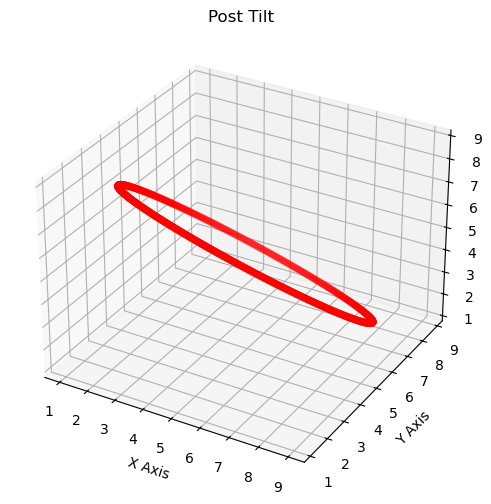

In [44]:
# Create a figure and 3D axis
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

x=circle_points[:,0]
y=circle_points[:,1]
z=circle_points[:,2]

# Create scatter plot
ax.scatter3D(x, y, z, color='red', marker='o')

# Labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Post Tilt')

Text(0.5, 0.92, 'Starting Circle')

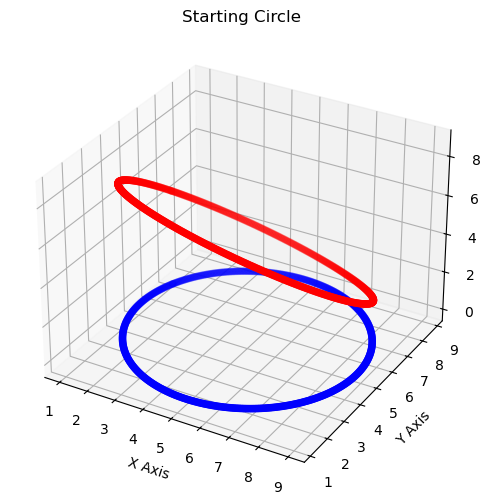

In [45]:
### Project the Points Down:

from skspatial.objects import Plane, Point, Vector
from skspatial.plotting import plot_3d

projected_points = project_into_xy_plane(circle_points)
    
x1=projected_points[:,0]
y1=projected_points[:,1]
z1=projected_points[:,2]

# Create scatter plot

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(x, y, z, color='red', marker='o')
ax.scatter3D(x1, y1, z1, color='blue', marker='o')

# Labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Starting Circle')



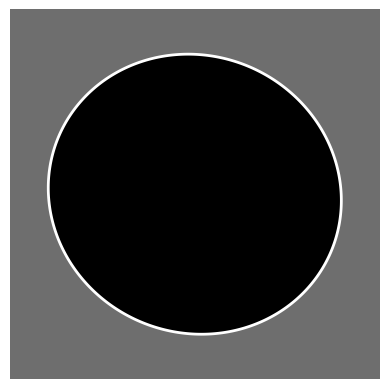

In [46]:
import matplotlib

fig, ax = plt.subplots() # Ensure equal aspect ratio for true shape


plot_patch = matplotlib.patches.Polygon(projected_points[:, 0:2], 
                                        closed=True,
                                        edgecolor='w',
                                        facecolor='k',
                                        lw=2)

# Add the ellipse to the axes
ax.set_aspect('equal')
ax.add_patch(plot_patch)

# Set plot limits and show
ax.set_facecolor((.43, .43, .43))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

##Make the Axes Invisible - so it looks like a microscope picture
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)
#ax.set_axis_off()
#ax.set_title("Matplotlib Ellipse Patch")
plt.savefig('Circle2.png', dpi=300, bbox_inches='tight')
plt.show()


## Optimize for Circularity

1) Calculate Circularity Metric on Current Image
2) Determine how to change alpha and beta
3) Call update image function

In [62]:
def tilt_update_math(normal, alpha_tilt, beta_tilt):
    '''Take in the current normal and do all the tilt update math
    Parameters:
        normal: the normal to the hole in the grid (imagined as a plane)
        alpha_tilt: how much to tilt in alpha (degrees since microscopists work in degrees)
        beta_tilt: how much to tilt in beta (degrees)
    Returns:
        new_normal: normal of hole after grid is tilted, [x,y,z] numpy array
        theta_r: azimuth, radians
        phi_r: zenith, radians
    '''
    
    norm_alpha = rotate_vector_alpha(normal, alpha_tilt)
    new_normal = rotate_vector_beta(norm_alpha, beta_tilt)

    ##Recalculate azimuth and zenith:

    theta_r = calculate_angle(norm_alpha, np.array([0,0,1]))
    phi_r = calculate_azimuth(norm_beta)
    
    ##Making a plot that looks like a hole-------------------------------------------------------------
    
    
    ##Step 1) Make a Circle (which is an array of points)----------------------------------------------
    circle_points = np.zeros([len(t_range),3])

    i=0
    for t in t_range:
        current_point = circle_point(theta_r, phi_r, center, t)
        circle_points[i,:] = current_point
        i+=1
        
    
    ##Step 2) Project those points into the xy plane to simulate a 2D image---------------------------
    
    projected_points = project_into_xy_plane(circle_points)
    
    ##Step 3) Use patches to turn that projection into a filled in image of an ellipse---------------
    
    fig, ax = plt.subplots() # Ensure equal aspect ratio for true shape


    plot_patch = matplotlib.patches.Polygon(projected_points[:, 0:2], 
                                        closed=True,
                                        edgecolor='w',
                                        facecolor='k',
                                        lw=2)

    # Add the ellipse to the axes
    ax.set_aspect('equal')
    ax.add_patch(plot_patch)
    
    ax.set_facecolor((.43, .43, .43))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)

    ##Make the Axes Invisible - so it looks like a microscope picture
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)
    
    '''
    # Save the figure to a BytesIO buffer
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    
    # Close the plot
    plt.close(fig)
    
    # Open the image from the buffer using PIL
    buf.seek(0)
    img = Image.open(buf)
    
    return img
    '''
    
    ##Step 3) Save as a PNG for Image Analysis-----------------------------------------------
    ##NB: This function overwrites the last image, we are not saving them all
    
    plt.savefig('Most_Recent_Circle.png', dpi=300, bbox_inches='tight')

    
    return new_normal, theta_r, phi_r

def tilt_update_image(theta_r, phi_r):
    '''Take in the azimuth and zenith angles (post tilting) and deliver the new image
    Parameters:
        theta_r: azimuth, radians
        phi_r: zenith, radians
    Returns:
        An image of a tilted hole, using Pillow
    '''
    
    ##Making a plot that looks like a hole-------------------------------------------------------------
    
    
    ##Step 1) Make a Circle (which is an array of points)----------------------------------------------
    circle_points = np.zeros([len(t_range),3])

    i=0
    for t in t_range:
        current_point = circle_point(theta_r, phi_r, center, t)
        circle_points[i,:] = current_point
        i+=1
        
    
    ##Step 2) Project those points into the xy plane to simulate a 2D image---------------------------
    
    projected_points = project_into_xy_plane(circle_points)
    
    ##Step 3) Use patches to turn that projection into a filled in image of an ellipse---------------
    
    fig, ax = plt.subplots() # Ensure equal aspect ratio for true shape


    plot_patch = matplotlib.patches.Polygon(projected_points[:, 0:2], 
                                        closed=True,
                                        edgecolor='w',
                                        facecolor='k',
                                        lw=2)

    # Add the ellipse to the axes
    ax.set_aspect('equal')
    ax.add_patch(plot_patch)
    
    ax.set_facecolor((.43, .43, .43))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)

    ##Make the Axes Invisible - so it looks like a microscope picture
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)
    
    '''
    # Save the figure to a BytesIO buffer
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    
    # Close the plot
    plt.close(fig)
    
    # Open the image from the buffer using PIL
    buf.seek(0)
    img = Image.open(buf)
    
    return img
    '''
    
    ##Step 3) Save as a PNG for Image Analysis-----------------------------------------------
    ##NB: This function overwrites the last image, we are not saving them all
    
    subfolder = 'Data'
    filename = 'Most_Recent_Circle.png'
    
    filepath = os.path.join(os.getcwd(), subfolder, filename)
    
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)
    
    plt.savefig(filepath, dpi=300, bbox_inches='tight')

        

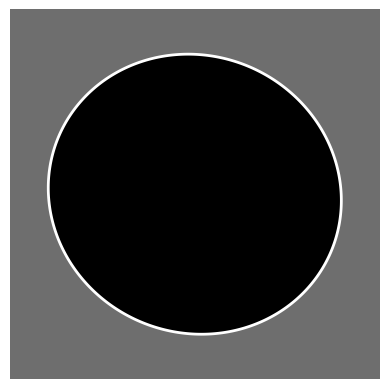

In [63]:
#Testing the image return function:

tilt_update_image(theta_r, phi_r)

img = Image.open('Most_Recent_Circle.png')

# Display the image
img.show()

In [77]:
def circle_optimize(input_folder, epsilon_ratio=0.001):
    """
    Input:
        input_folder: folder containing ONLY raw images to analyze
                      (e.g. .../Code/Data)
    Output folders (created in parent of input_folder, e.g. .../Code):
        - mask_overlay/
        - mask_polygon/
        - circle_optimize_data/
            - least_squares_images/
            - least_squares_error_plots/
        - circle_optimize_data/circle_optimize_table.csv
    """

    import os
    import cv2
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from skimage.measure import ransac, CircleModel
    from scipy.optimize import least_squares

    # -----------------------------
    # Paths (outputs next to code)
    # -----------------------------
    input_folder = os.path.abspath(input_folder)
    base_folder = os.path.dirname(input_folder)  # parent of Data (= code folder)

    mask_overlay_folder = os.path.join(base_folder, "mask_overlay")
    mask_polygon_folder = os.path.join(base_folder, "mask_polygon")
    data_folder = os.path.join(base_folder, "circle_optimize_data")
    ls_image_folder = os.path.join(data_folder, "least_squares_images")
    ls_err_plot_folder = os.path.join(data_folder, "least_squares_error_plots")

    for f in [mask_overlay_folder, mask_polygon_folder,
              data_folder, ls_image_folder, ls_err_plot_folder]:
        os.makedirs(f, exist_ok=True)

    # -----------------------------
    # Collect image filenames only
    # -----------------------------
    valid_exts = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")

    image_names = [
        f for f in os.listdir(input_folder)
        if os.path.isfile(os.path.join(input_folder, f))
        and f.lower().endswith(valid_exts)
    ]

    if not image_names:
        raise ValueError(f"No image files found in: {input_folder}")

    df = pd.DataFrame(image_names, columns=["image"])

    # -----------------------------
    # Helper: make masks for each image
    # -----------------------------
    for filename in image_names:
        input_path = os.path.join(input_folder, filename)

        img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not read image: {input_path}")

        # 1. Blur
        blur = cv2.GaussianBlur(img, (7, 7), 0)

        # 2. Threshold (invert because object is dark)
        _, thresh = cv2.threshold(
            blur, 0, 255,
            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

        # 3. Morphological closing
        kernel = np.ones((9, 9), np.uint8)
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        # 4. Find contours
        contours, _ = cv2.findContours(
            closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        if not contours:
            raise ValueError(f"No contours found in image: {input_path}")

        # 5. Largest contour
        cnt = max(contours, key=cv2.contourArea)

        # 6. Polygon approximation
        eps = epsilon_ratio * cv2.arcLength(cnt, True)
        poly = cv2.approxPolyDP(cnt, eps, True)

        # 7. Overlay mask on image
        overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        mask_tmp = np.zeros_like(img, dtype=np.uint8)
        cv2.fillPoly(mask_tmp, [poly], 255)
        overlay[mask_tmp == 255] = (0, 0, 255)

        name, ext = os.path.splitext(filename)
        mask_overlay_path = os.path.join(mask_overlay_folder,
                                         f"mask_overlay_{name}{ext}")
        cv2.imwrite(mask_overlay_path, overlay)

        # 8. Save polygon mask (binary PNG)
        mask = np.zeros_like(img, dtype=np.uint8)
        cv2.fillPoly(mask, [poly], 255)
        mask_polygon_path = os.path.join(mask_polygon_folder,
                                         f"mask_polygon_{name}.png")
        cv2.imwrite(mask_polygon_path, mask)

    # -----------------------------
    # Helper: circularity measure
    # -----------------------------
    def compute_circularity(image_name):
        input_path = os.path.join(input_folder, image_name)

        img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None

        blur = cv2.GaussianBlur(img, (7, 7), 0)
        _, thresh = cv2.threshold(
            blur, 0, 255,
            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

        contours, _ = cv2.findContours(
            thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        if not contours:
            return None

        cnt = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            return None

        circularity = 4 * np.pi * area / (perimeter ** 2)  # 1 = perfect circle [web:13]
        return circularity

    df["circularity"] = df["image"].apply(compute_circularity)

    # -----------------------------
    # Helper: least squares circle fit
    # -----------------------------
    def compute_least_squares(image_name):
        image_path = os.path.join(input_folder, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not read image: {image_path}")

        name, _ = os.path.splitext(image_name)
        mask_polygon_path = os.path.join(mask_polygon_folder,
                                         f"mask_polygon_{name}.png")
        mask = cv2.imread(mask_polygon_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Could not read mask: {mask_polygon_path}")

        _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
        )
        if not contours:
            raise ValueError(f"No mask contour found for: {mask_polygon_path}")

        cnt = max(contours, key=cv2.contourArea)

        # Subpixel refine
        cnt = cnt.astype(np.float32)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
                    40, 0.001)
        cv2.cornerSubPix(
            img,
            cnt,
            winSize=(5, 5),
            zeroZone=(-1, -1),
            criteria=criteria
        )

        pts = cnt.squeeze()  # (N, 2)
        if pts.ndim != 2 or pts.shape[0] < 3:
            raise ValueError(f"Not enough contour points for: {image_path}")

        # Uniform sampling to at most ~300 points
        step = max(1, len(pts) // 300)
        pts_sampled = pts[::step]
        x, y = pts_sampled[:, 0], pts_sampled[:, 1]

        data = np.column_stack([x, y])

        # Robust initial circle via RANSAC [web:131][web:137]
        model_robust, inliers = ransac(
            data,
            CircleModel,
            min_samples=3,
            residual_threshold=1.0,
            max_trials=1000
        )
        if model_robust is None or inliers is None or not np.any(inliers):
            raise ValueError(f"RANSAC failed for: {image_path}")

        x_in, y_in = data[inliers].T

        # Least squares refinement [web:13][web:132]
        def residuals(c):
            a, b, r = c
            return np.sqrt((x_in - a) ** 2 + (y_in - b) ** 2) - r

        a0, b0, r0 = model_robust.params
        res = least_squares(residuals, [a0, b0, r0])
        a, b, r = res.x

        residual = residuals([a, b, r])
        rmse = np.sqrt(np.mean(residual ** 2))
        arc_fraction = len(x_in) / len(x)

        # Plot circle overlay
        theta = np.linspace(0, 2 * np.pi, 500)
        xc = a + r * np.cos(theta)
        yc = b + r * np.sin(theta)

        plt.imshow(img, cmap='gray')
        plt.scatter(x, y, s=2, c='yellow')
        plt.plot(xc, yc, 'r', lw=2)
        plt.scatter(a, b, c='cyan')
        plt.axis('off')
        plt.tight_layout()

        ls_image_path = os.path.join(ls_image_folder,
                                     f"least_squares_{name}.png")
        plt.savefig(ls_image_path, bbox_inches='tight', pad_inches=0)
        plt.close()

        # Plot angular error
        angles = np.arctan2(y - b, x - a)
        errors = np.sqrt((x - a) ** 2 + (y - b) ** 2) - r

        plt.scatter(angles, errors, s=5)
        plt.axhline(0, color='k')
        plt.xlabel("Angle (rad)")
        plt.ylabel("Radial error (px)")
        ls_err_path = os.path.join(ls_err_plot_folder,
                                   f"ls_error_plot_{name}.png")
        plt.savefig(ls_err_path, bbox_inches='tight', pad_inches=0.1)
        plt.close()

        return rmse, arc_fraction

    df[["LS RMSE", "LS arc coverage"]] = df["image"].apply(
        lambda name: pd.Series(compute_least_squares(name))
    )

    # Save table
    table_path = os.path.join(data_folder, "circle_optimize_table.csv")
    df.to_csv(table_path, index=False)

    return df


In [80]:
##Extract the scalar value of circularity:
df = circle_optimize(input_folder="CirclePhotos")
circularity = age = df.iat[0, 1]


                    image  circularity   LS RMSE  LS arc coverage
0  Most_Recent_Circle.png      0.89738  0.456158          0.28863
0.8973803090168051


In [ ]:
##Optimize Loop